# Membership Inference using Handcrafted Threshold

## Setup

In [1]:
import matplotlib.pyplot as plt
import polars as pl

from config import MODELS, RUN_ID
from privacy_and_grokking.path_keeper import get_path_keeper

In [ ]:
pk = get_path_keeper()
pk.set_params({"run_id": RUN_ID})

## Data

In [ ]:
def process_single_step_logits(df: pl.DataFrame) -> pl.DataFrame:
    labels = df["correct_label"].unique().sort().to_list() 
    expressions = [
        pl.when(pl.col("correct_label") == label).then(pl.col(f"logit_{label}"))
        for label in labels
    ]
    return df.with_columns(
        pl.coalesce(*expressions).alias("correct_logit")
    )

single_step_logit_dfs = {}
for model in MODELS:
    pk.set_params({"model": model.name, "step": 100_000})

    df_train = pl.read_parquet(pk.TRAIN_LOGITS)
    df_test = pl.read_parquet(pk.TEST_LOGITS)

    single_step_logit_dfs[model.name] = (process_single_step_logits(df_train), process_single_step_logits(df_test))

In [ ]:
bounds = {
    MODELS[0].name: (0.98, 1.02),
    MODELS[1].name: (0.98, 1.02),
    MODELS[2].name: (0.98, 1.02),
    MODELS[3].name: (0.98, 1.02),
}
# LOWER_BOUND = 0.98
# UPPER_BOUND = 1.02

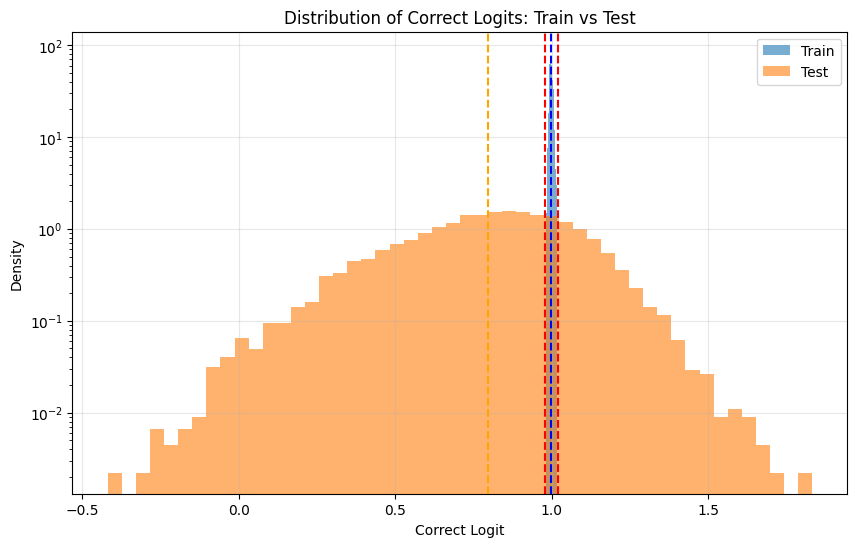

In [ ]:
for model in MODELS:
    lower_bound, upper_bound = bounds[model.name]
    df_train, df_test = single_step_logit_dfs[model.name]
    plt.figure(figsize=(10, 6))
    plt.hist(df_train["correct_logit"].to_numpy(), bins=50, alpha=0.6, label="Train", density=True)
    plt.hist(df_test["correct_logit"].to_numpy(), bins=50, alpha=0.6, label="Test", density=True)
    plt.xlabel("Correct Logit")
    plt.ylabel("Density")
    plt.yscale("log")
    plt.title("Distribution of Correct Logits: Train vs Test")
    plt.legend()
    plt.axvline(x=df_train["correct_logit"].mean(), color="blue", linestyle="--", label="Train Mean")
    plt.axvline(x=df_test["correct_logit"].mean(), color="orange", linestyle="--", label="Test Mean")
    plt.axvline(x=lower_bound, color="red", linestyle="--", label="Lower Bound")
    plt.axvline(x=upper_bound, color="red", linestyle="--", label="Upper Bound")
    plt.grid(True, alpha=0.3)
    # plt.xlim(lower_bound, upper_bound)
    plt.show()

In [39]:
# The values LOWER_BOUND and UPPER_BOUND were chosen based on the histogram visualization above (zooming in a bit).
df_train_inferred = df_train.with_columns(
    pl.when((pl.col("correct_logit") > LOWER_BOUND) & (pl.col("correct_logit") < UPPER_BOUND)).then(1).otherwise(0).alias("inferred_member")
)
df_test_inferred = df_test.with_columns(
    pl.when((pl.col("correct_logit") > LOWER_BOUND) & (pl.col("correct_logit") < UPPER_BOUND)).then(0).otherwise(1).alias("inferred_member")
)

In [40]:
df_train_inferred["inferred_member"].sum() / df_train_inferred.height, df_test_inferred["inferred_member"].sum() / df_test_inferred.height

(1.0, 0.945)

In [41]:
df_train_inferred.height, df_test_inferred.height

(1000, 10000)